### Importando librerias necesarias

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,TimeSeriesSplit
import matplotlib.pyplot as plt
from Crossvalidation import MultipleTimeSeriesCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,RocCurveDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from Backtesting import backtest_1day_hold,backtest_1day_hold_train_test,backtest_1day_hold_train_test_market,backtest_1day_hold_open
from Crossvalidation import MultipleTimeSeriesCV,plot_time_series_split,walk_forward_validation
import warnings
warnings.filterwarnings("ignore")

### Entrenamiento de Modelos

In [2]:
# Cargamos los datos originales
df = pd.read_csv('../spyconalfas.csv')

In [3]:
df

,Date,next movement,next returns,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,...,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day,Open
0,2013-10-15,1,0.013966,143.668381,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,...,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576,144.354126
1,2013-10-16,1,0.006683,145.674820,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,...,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005788,0.007397,144.531902
2,2013-10-17,1,0.006754,146.648422,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,...,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004462,0.003139,145.082203
3,2013-10-18,1,0.000058,147.638947,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,...,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002656,147.190248
4,2013-10-21,1,0.005791,147.647446,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,...,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249,147.689778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2022-10-07,0,-0.007635,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,...,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609,368.970001
2180,2022-10-10,0,-0.006333,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,...,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138,363.959991
2181,2022-10-11,0,-0.003298,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,...,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544,358.239990
2182,2022-10-12,1,0.026391,356.559998,-0.320899,0.091750,0.020725,-0.222222,-0.024332,-1.000000,...,-0.006333,-0.027894,-0.002328,0.030987,0.026401,-0.015464,-0.009893,0.010748,-0.003773,358.170013


<AxesSubplot:>

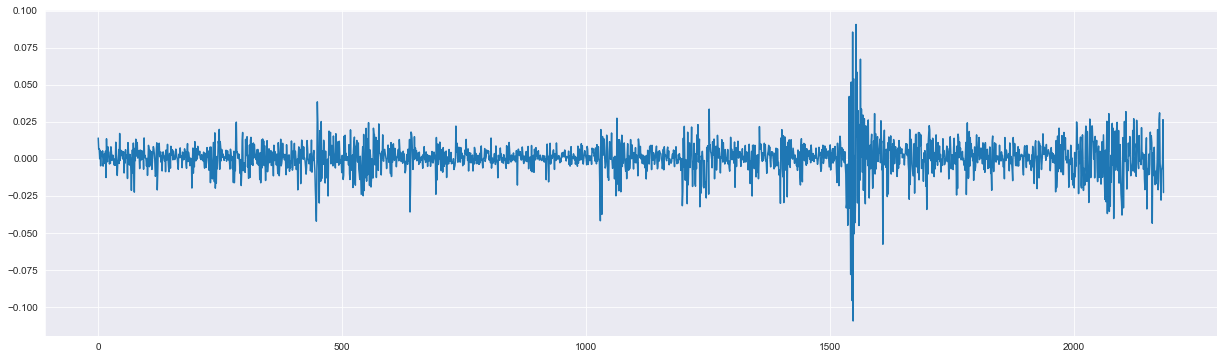

In [4]:
# Visualizamos los retornos
df['next returns'].plot(y='Date',figsize=(21,6))

In [5]:
# Separamos en X - (conjunto de entrenamiento) y Y - (etiquetas de los movimientos)
Y = df['next movement']
X = df
X.drop(['next movement','alpha53'],axis=1,inplace=True)

Tras haber separado las etquetas de los datos y haber eliminado Date y Alpha53, procedemos a separar en Train/Test:

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

fecha_inicio_train = X_train['Date'].iloc[0]
fecha_fin_train = X_train['Date'].iloc[-1]
fecha_inicio_test = X_test['Date'].iloc[0]
fecha_fin_test = X_test['Date'].iloc[-1]

print('Intervalo de entrenamiento:',fecha_inicio_train,'-',fecha_fin_train)
print('Intervalo de prueba:',fecha_inicio_test,'-',fecha_fin_test)

Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13


Intervalo de entrenamiento: 2013-10-15 - 2021-01-06
Intervalo de prueba: 2021-01-07 - 2022-10-13

In [7]:
X_train_open = X_train['Open']
X_test_open = X_test['Open']
X_train_close = X_train['Close']
X_test_close = X_test['Close']

Ahora tomamos los retornos, los necesitaremos para calcular el rendimiento de nuestro algoritmo:

In [8]:
X_train_ret = X_train['next returns']
X_test_ret = X_test['next returns']

In [9]:
X_train.drop(['next returns','Date','Open'],axis=1,inplace=True)
X_test.drop(['next returns','Date','Open'],axis=1,inplace=True)

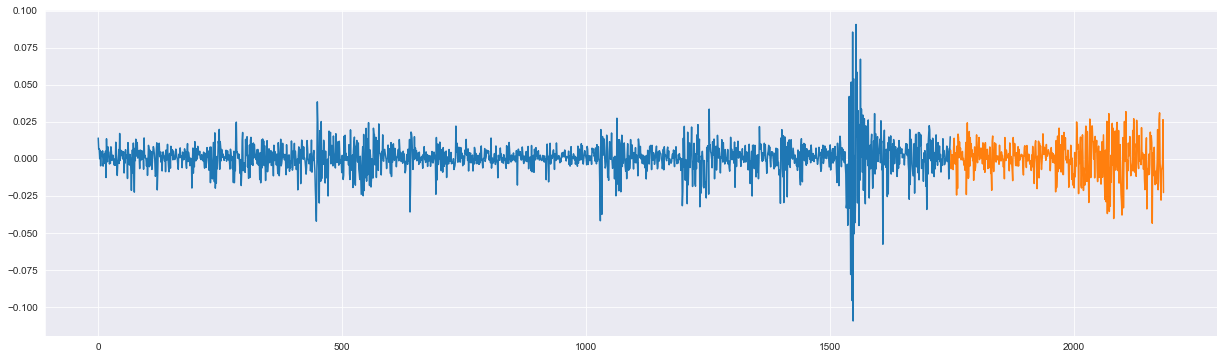

In [10]:
#Plotear Train/Test
plt.figure(figsize=(21,6))
plt.plot(X_train_ret)
plt.plot(X_test_ret)

Añadimos el preprocesado necesario:

In [11]:
X_train.describe()

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,...,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000
mean,226.303104,0.000049,0.095388,0.228628,-0.654137,-0.248861,-0.554503,-0.496759,-0.136334,0.496514,...,-0.333911,0.000563,0.000583,0.000480,0.000468,0.000482,0.000518,0.000596,0.000581,0.000572
std,53.555905,0.276679,0.451507,0.384418,0.326093,0.135071,0.670466,0.274108,2.716778,0.274474,...,0.238194,0.010977,0.011024,0.011037,0.011047,0.011055,0.011059,0.011055,0.011031,0.011051
min,143.668381,-0.443642,-0.978837,-0.895961,-1.000000,-0.500199,-1.000000,-1.000000,-20.312088,0.000397,...,-0.994652,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424,-0.109424
25%,180.501419,-0.177497,-0.242868,-0.011644,-1.000000,-0.364080,-1.000000,-0.731215,-1.134300,0.262520,...,-0.503908,-0.003064,-0.003136,-0.003173,-0.003173,-0.003194,-0.003183,-0.003109,-0.003064,-0.003048
50%,220.383194,0.002006,0.115439,0.263278,-0.777778,-0.247507,-1.000000,-0.492006,-0.100418,0.495231,...,-0.290415,0.000598,0.000637,0.000555,0.000549,0.000590,0.000637,0.000636,0.000652,0.000649
75%,266.555084,0.302447,0.444329,0.538762,-0.333333,-0.134723,-0.166667,-0.263189,0.698593,0.729928,...,-0.132510,0.005191,0.005209,0.005143,0.005097,0.005162,0.005209,0.005326,0.005214,0.005234
max,364.738770,0.302447,0.972121,0.937606,-0.111111,-0.000199,1.000000,-0.002398,28.222412,1.000000,...,-0.000411,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603,0.090603


In [12]:
X_test

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
1747,369.831207,0.302447,0.773566,-0.260968,-1.000000,-0.444156,-0.616667,-0.880895,-5.414337,0.037361,...,-0.196627,0.005979,-0.013614,0.001427,-0.001908,0.008591,0.003890,-0.003993,0.008618,-0.004427
1748,371.938354,0.302447,0.478898,-0.160313,-1.000000,-0.479656,-0.750000,-0.888489,-2.107147,0.876789,...,-0.380090,0.014858,0.006887,0.005081,0.001427,-0.001908,0.008591,-0.003576,-0.002055,0.010937
1749,369.431213,0.002006,0.571287,0.123307,-1.000000,-0.428400,-1.000000,-0.930855,2.507141,0.894674,...,-0.283838,0.005698,0.005979,-0.013614,0.005081,0.001427,-0.001908,-0.001685,0.002926,0.002104
1750,369.509247,-0.177497,-0.827823,0.323170,-0.777778,-0.438172,-1.000000,-0.796163,-0.078033,0.483704,...,-0.444268,-0.006741,0.014858,0.006887,-0.013614,0.005081,0.001427,0.000899,-0.008969,-0.000273
1751,370.504303,-0.320899,-0.865147,0.430441,-1.000000,-0.405265,-1.000000,-0.714628,-0.995056,0.271463,...,-0.058121,0.000211,0.005698,0.005979,0.006887,-0.013614,0.005081,0.003890,-0.000327,0.008618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,362.790009,-0.320899,0.664837,0.566897,-0.555556,-0.305345,0.250000,-0.986411,10.410004,0.990859,...,-0.356688,-0.010316,0.030987,-0.015464,-0.020889,0.019676,-0.002553,-0.017444,0.017965,-0.007609
2180,360.019989,-0.443642,0.522104,0.347362,-0.222222,-0.057439,-1.000000,-0.967626,2.770020,0.106518,...,-0.491979,-0.027894,-0.002328,0.026401,-0.015464,-0.020889,0.019676,-0.008400,0.006536,0.003138
2181,357.739990,-0.177497,0.448061,0.252213,-0.111111,-0.018548,-1.000000,-0.566347,-2.279999,0.133943,...,-0.391608,-0.007635,-0.010316,0.030987,0.026401,-0.015464,-0.020889,-0.016755,0.015535,-0.010544
2182,356.559998,-0.320899,0.091750,0.020725,-0.222222,-0.024332,-1.000000,-0.050759,-1.179993,0.247615,...,-0.247223,-0.006333,-0.027894,-0.002328,0.030987,0.026401,-0.015464,-0.009893,0.010748,-0.003773


In [13]:
cols_to_norm = ['Close','alpha54','alpha84']
scaler  = StandardScaler()

X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [14]:
X_train

,Close,alpha1,alpha2,alpha3,alpha4,alpha5,alpha7,alpha8,alpha9,alpha10,...,alpha99,-2 day,-4 day,-6 day,-7 day,-8 day,-9 day,-13 day,-23 day,-27 day
0,-1.543404,0.002006,0.837104,0.144324,-1.000000,-0.334463,-0.250000,-0.772182,1.049805,0.774245,...,-0.445462,0.003994,0.021558,-0.011647,-0.008645,0.007577,-0.009221,-0.004597,0.002249,0.009576
1,-1.505929,0.302447,0.630211,0.005426,-1.000000,-0.330275,-0.916667,-0.832934,-2.006439,0.157393,...,-0.630971,-0.007254,0.006443,0.000725,-0.011647,-0.008645,0.007577,-0.005328,0.005788,0.007397
2,-1.487744,0.302447,0.546596,0.036931,-1.000000,-0.335261,-1.000000,-0.823341,-0.973602,0.275437,...,-0.653264,0.013966,0.003994,0.021558,0.000725,-0.011647,-0.008645,0.007916,0.004462,0.003139
3,-1.469244,0.302447,0.609252,0.106372,-1.000000,-0.424411,-1.000000,-0.758993,-0.990524,0.272655,...,-0.732209,0.006683,-0.007254,0.006443,0.021558,0.000725,-0.011647,-0.000945,0.011574,-0.002656
4,-1.469085,0.302447,0.414525,0.514069,-1.000000,-0.420821,-1.000000,-0.754596,-0.008499,0.507552,...,-0.649283,0.006754,0.013966,0.003994,0.006443,0.021558,0.000725,-0.009221,-0.001676,0.002249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2.551185,-0.177497,0.434895,0.205681,-1.000000,-0.395891,-1.000000,-0.823741,-0.517029,0.370429,...,-0.203209,-0.001908,0.003890,-0.001685,-0.003576,-0.003993,0.005592,-0.001172,0.002785,-0.006848
1743,2.585622,0.302447,0.134440,0.153597,-0.888889,-0.326286,-0.483333,-0.733014,-1.843750,0.176868,...,-0.112299,0.001427,0.008591,0.000899,-0.001685,-0.003576,-0.003993,-0.004477,-0.004427,0.005994
1744,2.492879,0.002006,0.553204,-0.080359,-0.222222,-0.465496,-0.150000,-0.156675,4.965485,0.959459,...,-0.045660,0.005081,-0.001908,0.003890,0.000899,-0.001685,-0.003576,0.013519,0.010937,0.016114
1745,2.539158,-0.177497,0.663167,-0.024306,-0.555556,-0.082170,-0.366667,-0.171863,-2.477814,0.120032,...,-0.053065,-0.013614,0.001427,0.008591,0.003890,0.000899,-0.001685,0.001569,0.002104,-0.001542


Entrenamiento

In [ ]:
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier(),MLPClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost','ANN']
metricas = ['accuracy','roc_auc']
primero=True


param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.001,0.01,0.1,0.5,1],
    'max_iter' :[100,500,1000,10000],
    'alpha' : [0.001,0.01],
    'shuffle': [False]
}

#Gamma para todos menos lineal, degree solo para poly, C todos
param_svm = {
    'C' : [0.1,1,10],
    'kernel': ['linear','rbf','poly','sigmoid'],
    'gamma' :[0.01,0.1,1,1000]
}


param_rf = {
    'n_estimators':[100,150,200,250,300],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' : ['gini','entropy'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' : [0.001,0.01,0.05,0.1],
    'n_estimators' : [100,150,200,250,300,400],
    'gamma' : [0,1,5,10,20,30],
    'reg_alpha' : [0.001,0.01,0.1,1],
    'random_state': [42]
}

param_nn = {
    'hidden_layer_sizes' : [(42),(84),(168)],
    'learning_rate_init' : [0.001,0.01,0.1,1],
    'learning_rate' : ["constant","adaptive"],
    'activation' : ['logistic','tanh','relu'],
    'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e3],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_nn]
cv = TimeSeriesSplit(5)

for metrica in metricas:
    primero = True
    list_estimators_entrenados = []
    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        list_estimators_entrenados.append(busqueda)

    for estimator,name in zip(list_estimators_entrenados,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)

    plt.figure(figsize=(20,10))
    for estimator,name in zip(list_estimators_entrenados,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mejores parametros:( accuracy ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
Mejores parametros:( accuracy ) ANN {'activation': 'relu', 'alpha': 10.0, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 1, 'random_state': 42}
Win rate: (Regresión

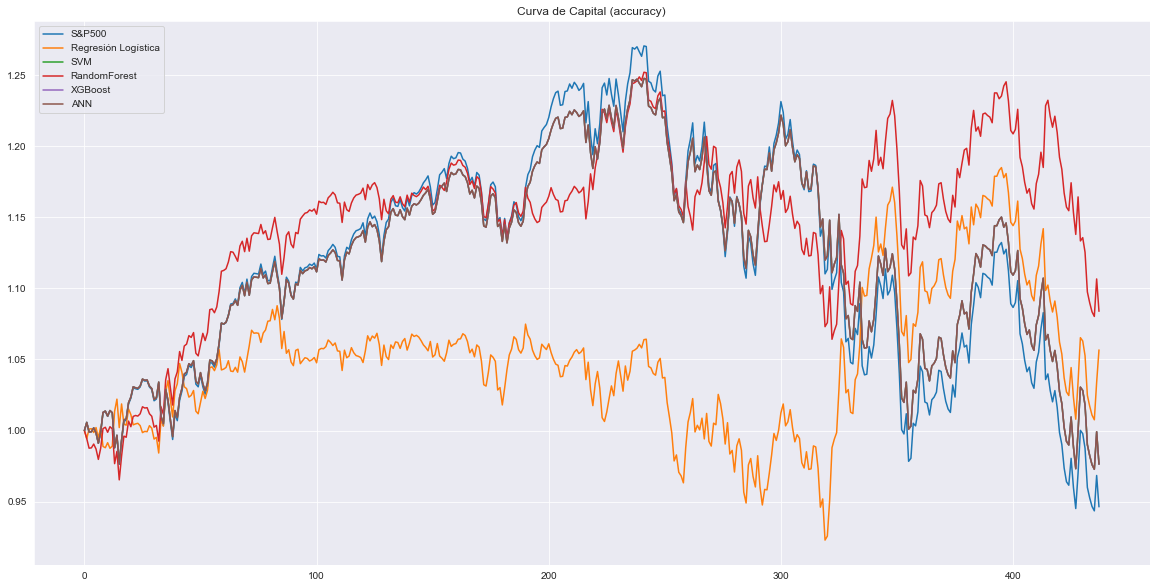

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Mejores parametros:( roc_auc ) RandomForest {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Mejores parametros:( roc_auc ) XGBoost {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
Mejores parametros:( roc_auc ) ANN {'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 1, 'random_state': 42}
Win rate: (Regresión Lo

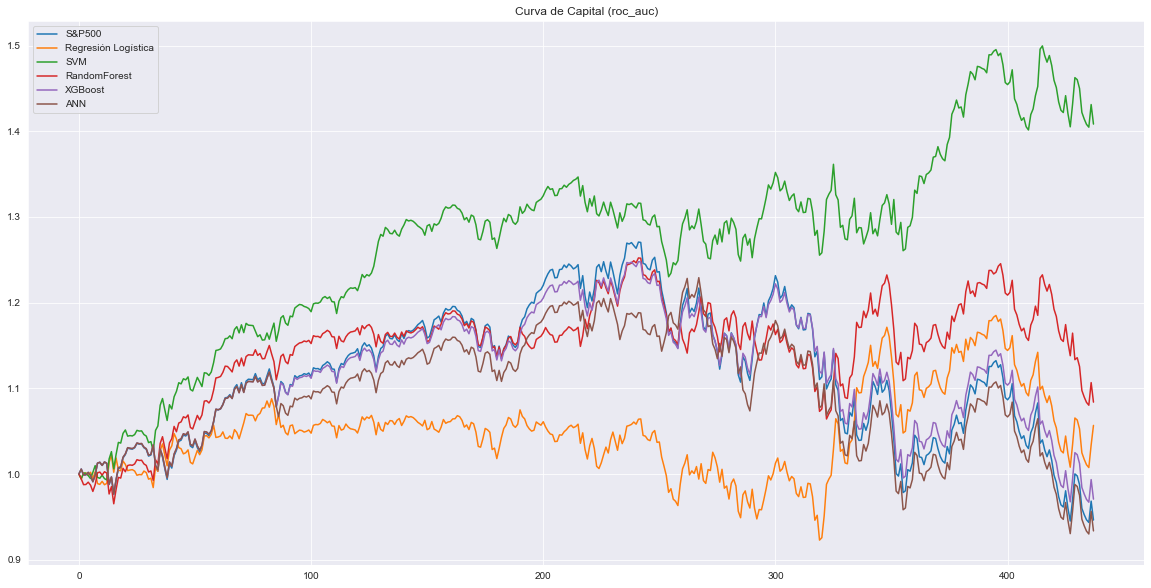

In [21]:
###############################################################################
####################################PRUEBA#####################################
###############################################################################
list_estimators = [SGDClassifier(),SVC(),RandomForestClassifier(),xgb.XGBClassifier(),MLPClassifier()]
list_names = ['Regresión Logística','SVM','RandomForest','XGBoost','ANN']
metricas = ['accuracy','roc_auc']
primero=True

#   Mejores parametros:( accuracy ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2', 'shuffle': False}
# Mejores parametros:( roc_auc ) Regresión Logística {'alpha': 0.001, 'eta0': 0.001, 'loss': 'log', 'max_iter': 500, 'penalty': 'l2', 'shuffle': False}
param_logreg = {
    'loss' : ['log'],
    'penalty' : ['l1','l2'],
    'eta0' : [0.01],
    'max_iter' :[1000],
    'alpha' : [0.01,0.001],
    'shuffle': [False]
}

#Mejores parametros:( accuracy ) SVM {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
#Mejores parametros:( roc_auc ) SVM {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
param_svm = {
    'C' : [0.1,10],
    'kernel': ['linear','rbf'],
    'gamma' :[0.1]
}

# Mejores parametros:( accuracy ) RandomForest {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150, 'random_state': 42}
#Mejores parametros:( roc_auc ) RandomForest {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100, 'random_state': 42}
param_rf = {
    'n_estimators':[100,250],
    'max_depth' : [4,7],
    'criterion' : ['gini'],
    'random_state': [42]
}

# Mejores parametros:( accuracy ) XGBoost {'reg_alpha': 1, 'random_state': 42, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 20}
# Mejores parametros:( roc_auc ) {'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 10}
param_xgb = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'n_estimators' : [200,300],
    'gamma' : [10],
    'reg_alpha' : [0.01],
    'random_state': [42]
}

param_nn = {
    'hidden_layer_sizes' : [(84)],
    'learning_rate_init' : [0.001,1],
    'learning_rate' : ["constant"],
    'activation' : ['tanh','relu'],
    'alpha' : [ 1e-3, 1e1],
    'random_state': [42]
}

list_params = [param_logreg,param_svm,param_rf,param_xgb,param_nn]
cv = TimeSeriesSplit(5)
list_estimators_entrenados_accuracy=[]
list_estimators_entrenados_roc_auc=[]

for metrica in metricas:
    primero = True

    for estimator,param in zip(list_estimators,list_params):
        if not isinstance(estimator,xgb.XGBClassifier):
            busqueda = GridSearchCV(estimator=estimator,param_grid=param,verbose=1,scoring=metrica,refit=True)
        else:
            busqueda = RandomizedSearchCV(estimator=estimator,param_distributions=param,verbose=1,scoring=metrica,refit=True)
        busqueda.fit(X_train,Y_train)
        if(metrica=='accuracy'):
            list_estimators_entrenados_accuracy.append(busqueda)
        else:
            list_estimators_entrenados_roc_auc.append(busqueda)


    if(metrica=='accuracy'):
        lista = list_estimators_entrenados_accuracy
    else:
        lista = list_estimators_entrenados_roc_auc

    for estimator,name in zip(lista,list_names):
        print('Mejores parametros:(',metrica,')',name,estimator.best_params_)
        Y_pred = estimator.predict(X_train)
        mat = ConfusionMatrixDisplay.from_predictions(Y_train,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('Matrices de Confusion/{}_Confusion_Mat_{}_Train.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_train,Y_pred)
        display.figure_.savefig('Curvas ROC/{}_ROC_Curve_{}_Train.jpg'.format(name,metrica))
        plt.close(display.figure_)
        Y_pred = estimator.predict(X_test)
        mat = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
        plt.grid(False)
        mat.figure_.savefig('Matrices de Confusion/{}_Confusion_Mat_{}_Test.jpg'.format(name,metrica))
        plt.close(mat.figure_)
        display = RocCurveDisplay.from_predictions(Y_test,Y_pred)
        display.figure_.savefig('Curvas ROC/{}_ROC_Curve_{}_Test.jpg'.format(name,metrica))
        plt.close(display.figure_)





    plt.figure(figsize=(20,10))

    for estimator,name in zip(lista,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold(X_test_ret,Y_pred,show_market=mercado,verbose=0,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

Win rate: (Regresión Logística) 0.5296803652968036
Win rate: (SVM) 0.5319634703196348
Win rate: (RandomForest) 0.5296803652968036
Win rate: (XGBoost) 0.5319634703196348
Win rate: (ANN) 0.5319634703196348


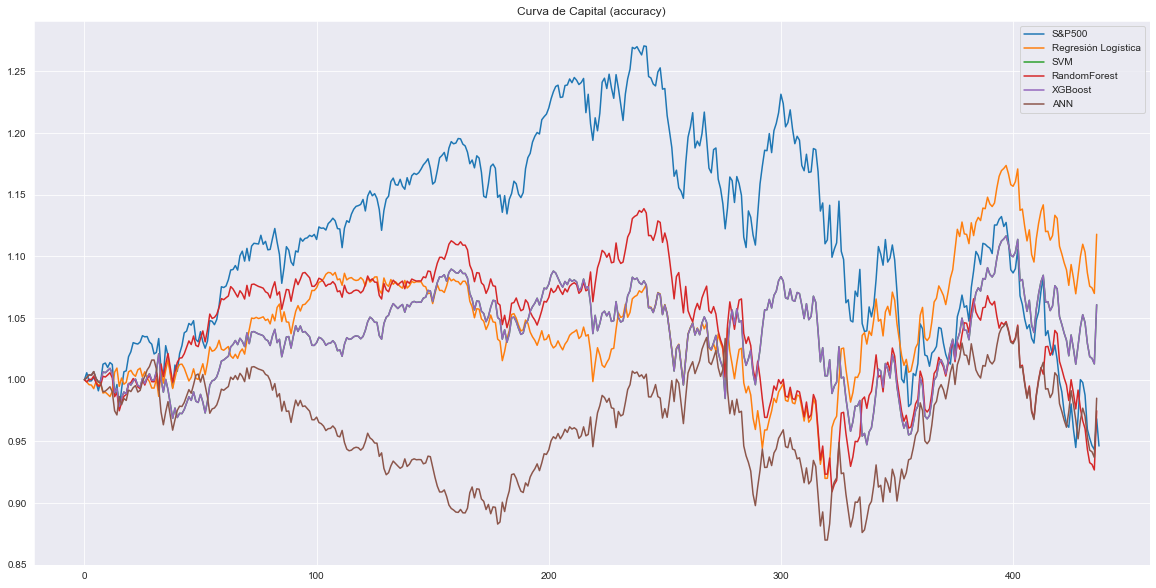

Win rate: (Regresión Logística) 0.5296803652968036
Win rate: (SVM) 0.5296803652968036
Win rate: (RandomForest) 0.5296803652968036
Win rate: (XGBoost) 0.5319634703196348
Win rate: (ANN) 0.5319634703196348


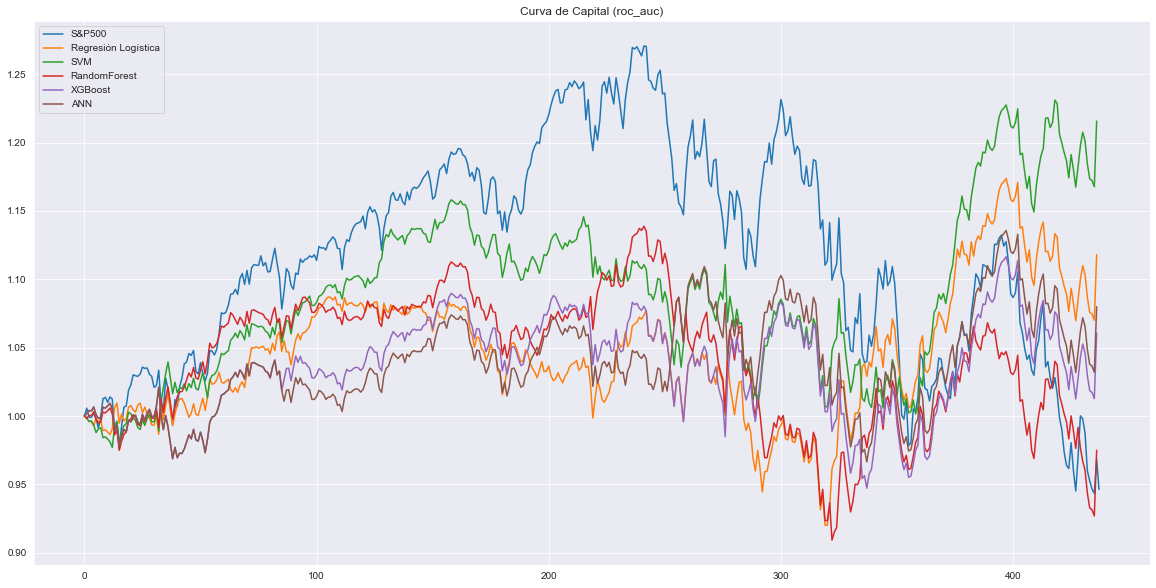

In [17]:



for metrica in metricas:
    plt.figure(figsize=(20,10))
    if(metrica=='accuracy'):
        lista = list_estimators_entrenados_accuracy
    else:
        lista = list_estimators_entrenados_roc_auc

    primero = True
    for estimator,name in zip(lista,list_names):
        Y_pred = estimator.predict(X_test)
        if primero:
            mercado=1
            primero=False
        else:
            mercado=0
        backtest_1day_hold_open(X_test_open,X_test_close,X_test_ret,Y_pred,verbose=0,show_market=mercado,label=name)
    plt.title('Curva de Capital ({})'.format(metrica))
    plt.legend()
    plt.show()

In [20]:
print('-------MEJORES PARAMETROS ACCURACY-------')
for estimator in list_estimators_entrenados_accuracy:
    print(estimator.best_params_)
print('-------MEJORES PARAMETROS ROC AUC-------')
for estimator in list_estimators_entrenados_roc_auc:
    print(estimator.best_params_)

-------MEJORES PARAMETROS ACCURACY-------
{'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
{'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'random_state': 42}
-------MEJORES PARAMETROS ROC AUC-------
{'alpha': 0.001, 'eta0': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'shuffle': False}
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
{'reg_alpha': 0.01, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 10}
{'activation': 'tanh', 'alpha': 10.0, 'hidden_layer_sizes': 84, 'learning_rate': 'constant', 'learning_rate_

### Código para visualizar un arbol

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(list_estimators_entrenados[2].best_estimator_.estimators_[6], out_file='tree.dot',
                feature_names = X_train.columns,
                class_names = ['up','down'],
                rounded = True, proportion = False,
                precision = 2, filled = True)

list_estimators_entrenados[2].best_estimator_.estimators_[6]

In [ ]:
import os
os.system('dot -Tpng tree.dot -o tree.png')

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10),dpi=600)
plot_tree(list_estimators_entrenados[2].best_estimator_.estimators_[6],feature_names=X_train.columns ,max_depth=3,filled=True,rounded=True)